Veri Kümesinin Hikayesi

1)Veri Kümesinin Kaynağı:
Bu çalışma için kullanılan veri kümeleri, Ulusal Biyoteknoloji Bilgi Merkezi (NCBI) tarafından sağlanmıştır. Kartal veri kümesi [KL869122.1](https://www.ncbi.nlm.nih.gov/nuccore/KL869122.1) ve baykuş veri kümesi [ML982583.1](https://www.ncbi.nlm.nih.gov/nuccore/ML982583.1) numaralı erişim kodlarıyla NCBI GenBank veritabanından alınmıştır.

2)Veri Kümesinin Toplanma Yöntemi:
Veri kümeleri, genetik dizilim analizleri kullanılarak toplanmıştır. Kartal ve baykuş türlerine ait DNA dizilimleri, laboratuvar ortamında dizilenmiş ve GenBank veritabanına yüklenmiştir.

3)Veri Kümesinin Amacı:
Bu veri kümeleri, kartal ve baykuş türlerinin genetik yapısını incelemek ve karşılaştırmak amacıyla toplanmıştır. Bu türlerin genetik farklılıklarını ve benzerliklerini belirlemek için bu veri kümeleri kullanılmaktadır.

4)Veri Kümesinin İçeriği:
Veri kümeleri, kartal ve baykuş türlerine ait DNA dizilimlerini içermektedir. Her bir veri kümesi, belirli bir türün DNA dizilimlerini temsil eden sekanslardan oluşmaktadır. Dizilimler, FASTA formatında saklanmaktadır.

5)Veri Kümesinin Kullanım Alanları:
Bu veri kümeleri, biyoinformatik ve genetik araştırmalar için kullanılabilir. Özellikle, türler arası genetik farklılıkların belirlenmesi, evrimsel ilişkilerin incelenmesi ve türlerin genetik çeşitliliğinin anlaşılması için değerlidir. Ayrıca, makine öğrenmesi modelleri kullanılarak türlerin sınıflandırılması ve genetik özelliklerin tahmin edilmesi gibi uygulamalarda da kullanılabilir.

Kullandığım datasetlerin linkleri:



Kartal link https://www.ncbi.nlm.nih.gov/nuccore/KL869122.1

Baykus link https://www.ncbi.nlm.nih.gov/nuccore/ML982583.1

1. Gerekli Kütüphaneleri Yükleme


In [1]:
# Gerekli kütüphanelerin import edilmesi
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    accuracy_score,
)
import seaborn as sns
from imblearn.over_sampling import SMOTE

2. Veri Setini Yükleme

In [2]:
# Kartal ve baykuş DNA sekanslarının yüklenmesi
kartal_df = pd.read_csv(
    "sequence_kartal.fasta", sep="\t", header=None, names=["Sequence"]
)

baykus_df = pd.read_csv(
    "sequence_baykus.fasta", sep="\t", header=None, names=["Sequence"]
)

3. Eksik Verilerin Kontrolü ve Temizliği

In [3]:
# Eksik verilerin kontrolü ve temizlenmesi
kartal_df.dropna(inplace=True)
baykus_df.dropna(inplace=True)


4. Sekans Uzunluklarını Özellik Olarak Ekleyip Filtreleme

In [4]:
# Her DNA sekansının uzunluğunun bir özellik olarak eklenmesi
kartal_df["Length"] = kartal_df["Sequence"].apply(len)
baykus_df["Length"] = baykus_df["Sequence"].apply(len)


5.Nükleotid frekanslarını hesaplama

In [5]:
# Nükleotid frekanslarını hesaplayan bir fonksiyon tanımlama
def nucleotide_frequencies(sequence):
    return pd.Series(
        {
            "A_freq": sequence.count("A") / len(sequence),
            "T_freq": sequence.count("T") / len(sequence),
            "C_freq": sequence.count("C") / len(sequence),
            "G_freq": sequence.count("G") / len(sequence),
        }
    )

# Nükleotid frekanslarının kartal ve baykuş veri setlerine eklenmesi
kartal_df = pd.concat(
    [kartal_df, kartal_df["Sequence"].apply(nucleotide_frequencies)], axis=1
)
baykus_df = pd.concat(
    [baykus_df, baykus_df["Sequence"].apply(nucleotide_frequencies)], axis=1
)

6.Çok kısa sekansları kaldırma

In [6]:
# Sekans uzunluğu 10'dan küçük olan kayıtların filtrelenmesi
kartal_df = kartal_df[kartal_df["Length"] > 10]
baykus_df = baykus_df[baykus_df["Length"] > 10]

7. Etiketler Ekleyip Veri Setlerini Birleştirme

In [7]:
# Veri setlerine etiket eklenmesi (kartal: 0, baykuş: 1)
kartal_df["Label"] = 0  # Kartal: 0
baykus_df["Label"] = 1  # Baykus: 1

# Kartal ve baykuş veri setlerinin birleştirilmesi
combined_df = pd.concat([kartal_df, baykus_df], ignore_index=True)

# Etiket dağılımının kontrol edilmesi
print("Etiket dağılımı:\n", combined_df["Label"].value_counts())

Etiket dağılımı:
 Label
1    21060
0    13130
Name: count, dtype: int64


8. SMOTE Uygulama

In [8]:
# SMOTE ile dengesiz veri setini dengeleme
X = combined_df[["Length", "A_freq", "T_freq", "C_freq", "G_freq"]]
y = combined_df["Label"]
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

9. Eğitim ve Test Setine Ayırma

In [9]:
# Dengelenmiş veri setinin eğitim ve test setlerine ayrılması
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42
)

10.Random Forest Modelini Eğitme ve Tahmin

In [10]:
# Random Forest modelinin eğitimi
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Test seti için tahmin yapılması
y_pred = model.predict(X_test)

11.Performans Değerlendirmesi

In [11]:
# Sınıflandırma raporunun ve doğruluk oranının yazdırılması
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Accuracy hesaplama ve yazdırma
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.68      0.70      4212
           1       0.70      0.74      0.72      4212

    accuracy                           0.71      8424
   macro avg       0.71      0.71      0.71      8424
weighted avg       0.71      0.71      0.71      8424

Accuracy: 0.71


12.Karışıklık Matrisi

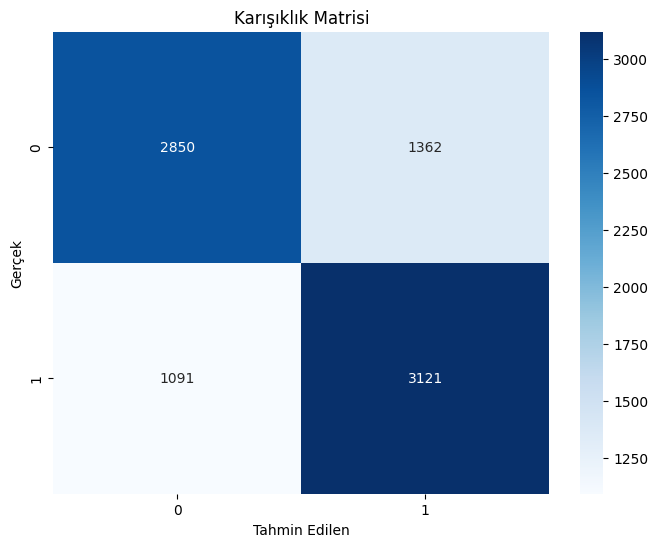

In [12]:
# Karışıklık matrisinin görselleştirilmesi
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Karışıklık Matrisi")
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek")
plt.show()

13.Sekans Uzunluğu Dağılımı

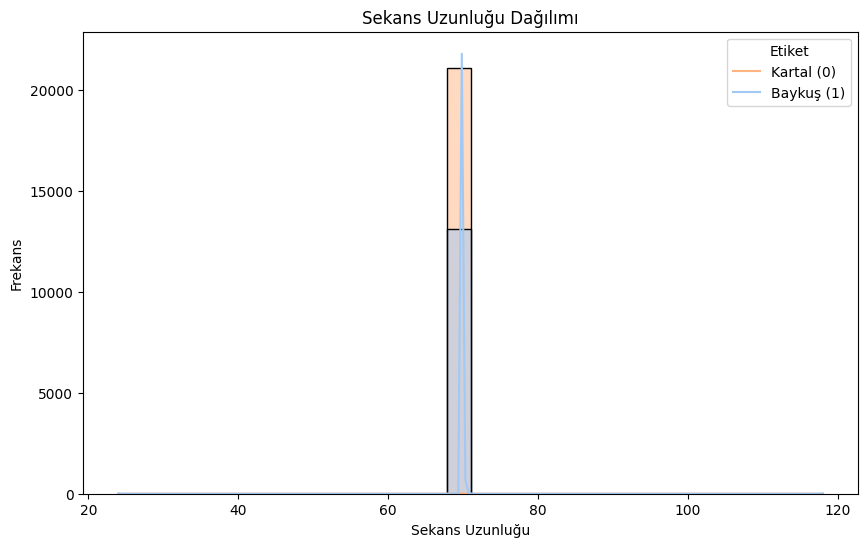

In [13]:
# Sekans uzunluğu dağılım grafiği
plt.figure(figsize=(10, 6))
sns.histplot(
    data=combined_df, x="Length", hue="Label", kde=True, bins=30, palette="pastel"
)
plt.title("Sekans Uzunluğu Dağılımı")
plt.xlabel("Sekans Uzunluğu")
plt.ylabel("Frekans")
plt.legend(["Kartal (0)", "Baykuş (1)"], title="Etiket")
plt.show()


14.ROC Eğrisi

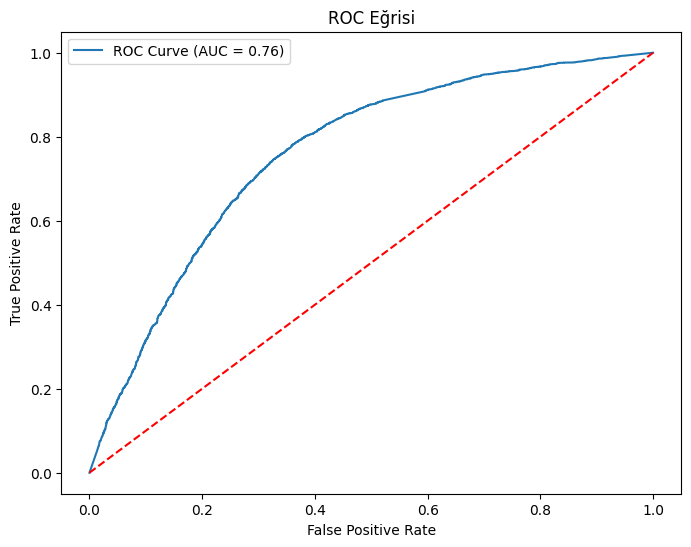

In [14]:
# ROC eğrisinin çizilmesi
y_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "r--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Eğrisi")
plt.legend()
plt.show()